In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Optimizing Vision Transformer Model for Deployment

[Jeff Tang](https://github.com/jeffxtang),
[Geeta Chauhan](https://github.com/gchauhan/)

Vision Transformer models apply the cutting-edge attention-based
transformer models, introduced in Natural Language Processing to achieve
all kinds of the state of the art (SOTA) results, to Computer Vision
tasks. Facebook Data-efficient Image Transformers [DeiT](https://ai.facebook.com/blog/data-efficient-image-transformers-a-promising-new-technique-for-image-classification)
is a Vision Transformer model trained on ImageNet for image
classification.

In this tutorial, we will first cover what DeiT is and how to use it,
then go through the complete steps of scripting, quantizing, optimizing,
and using the model in iOS and Android apps. We will also compare the
performance of quantized, optimized and non-quantized, non-optimized
models, and show the benefits of applying quantization and optimization
to the model along the steps.


## What is DeiT

Convolutional Neural Networks (CNNs) have been the main models for image
classification since deep learning took off in 2012, but CNNs typically
require hundreds of millions of images for training to achieve the
SOTA results. DeiT is a vision transformer model that requires a lot less
data and computing resources for training to compete with the leading
CNNs in performing image classification, which is made possible by two
key components of of DeiT:

-  Data augmentation that simulates training on a much larger dataset;
-  Native distillation that allows the transformer network to learn from
   a CNN’s output.

DeiT shows that Transformers can be successfully applied to computer
vision tasks, with limited access to data and resources. For more
details on DeiT, see the [repo](https://github.com/facebookresearch/deit)
and [paper](https://arxiv.org/abs/2012.12877).




## Classifying Images with DeiT

Follow the ``README.md`` at the DeiT repository for detailed information on how to
classify images using DeiT, or for a quick test, first install the
required packages:

```python
pip install torch torchvision timm pandas requests
```


In [3]:
pip install torch torchvision timm pandas requests


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.6 MB/s eta 0:00:00


To run in Google Colab, install dependencies by running the following command:

```python
!pip install timm pandas requests
```


then run the script below:



In [4]:
from PIL import Image
import torch
import timm
import requests
import torchvision.transforms as transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

print(torch.__version__)
# should be 1.8.0


model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.eval()

transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

img = Image.open(requests.get("https://raw.githubusercontent.com/pytorch/ios-demo-app/master/HelloWorld/HelloWorld/HelloWorld/image.png", stream=True).raw)
img = transform(img)[None,]
out = model(img)
clsidx = torch.argmax(out)
print(clsidx.item())

2.0.1+cu118


Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth
100%|██████████| 330M/330M [00:02<00:00, 147MB/s]


269


The output should be 269, which, according to the ImageNet list of class
index to [labels file](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), maps to ``timber
wolf, grey wolf, gray wolf, Canis lupus``.

Now that we have verified that we can use the DeiT model to classify
images, let’s see how to modify the model so it can run on iOS and
Android apps.




In [22]:
import matplotlib.pyplot as plt
from PIL import Image

In [12]:
img.shape

torch.Size([1, 3, 224, 224])

In [23]:
loctransform = transforms.ToPILImage()

In [25]:
testimg = Image.open(requests.get("https://raw.githubusercontent.com/pytorch/ios-demo-app/master/HelloWorld/HelloWorld/HelloWorld/image.png", stream=True).raw)

In [24]:
img2 = loctransform(img)

ValueError: ignored

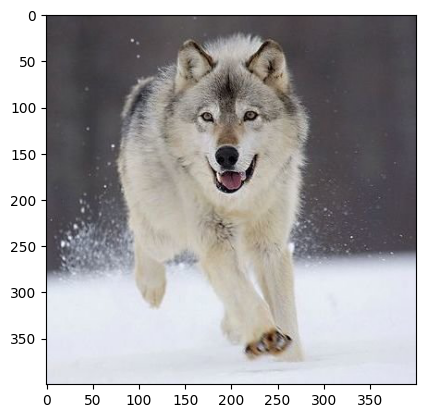

In [26]:
plt.imshow( testimg )


## Scripting DeiT
To use the model on mobile, we first need to script the
model. See the [Script and Optimize recipe](https://pytorch.org/tutorials/recipes/script_optimized.html) for a
quick overview. Run the code below to convert the DeiT model used in the
previous step to the TorchScript format that can run on mobile.




In [27]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.eval()
scripted_model = torch.jit.script(model)
scripted_model.save("fbdeit_scripted.pt")

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


The scripted model file ``fbdeit_scripted.pt`` of size about 346MB is
generated.




## Quantizing DeiT
To reduce the trained model size significantly while
keeping the inference accuracy about the same, quantization can be
applied to the model. Thanks to the transformer model used in DeiT, we
can easily apply dynamic-quantization to the model, because dynamic
quantization works best for LSTM and transformer models (see [here](https://pytorch.org/docs/stable/quantization.html?highlight=quantization#dynamic-quantization)
for more details).

Now run the code below:




In [28]:
# Use 'x86' for server inference (the old 'fbgemm' is still available but 'x86' is the recommended default) and ``qnnpack`` for mobile inference.
backend = "x86" # replaced with ``qnnpack`` causing much worse inference speed for quantized model on this notebook
model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend

quantized_model = torch.quantization.quantize_dynamic(model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8)
scripted_quantized_model = torch.jit.script(quantized_model)
scripted_quantized_model.save("fbdeit_scripted_quantized.pt")

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


This generates the scripted and quantized version of the model
``fbdeit_quantized_scripted.pt``, with size about 89MB, a 74% reduction of
the non-quantized model size of 346MB!




You can use the ``scripted_quantized_model`` to generate the same
inference result:




In [ ]:
out = scripted_quantized_model(img)
clsidx = torch.argmax(out)
print(clsidx.item())
# The same output 269 should be printed

## Optimizing DeiT
The final step before using the quantized and scripted
model on mobile is to optimize it:




In [ ]:
from torch.utils.mobile_optimizer import optimize_for_mobile
optimized_scripted_quantized_model = optimize_for_mobile(scripted_quantized_model)
optimized_scripted_quantized_model.save("fbdeit_optimized_scripted_quantized.pt")

The generated ``fbdeit_optimized_scripted_quantized.pt`` file has about the
same size as the quantized, scripted, but non-optimized model. The
inference result remains the same.




In [ ]:
out = optimized_scripted_quantized_model(img)
clsidx = torch.argmax(out)
print(clsidx.item())
# Again, the same output 269 should be printed

## Using Lite Interpreter

To see how much model size reduction and inference speed up the Lite
Interpreter can result in, let’s create the lite version of the model.




In [ ]:
optimized_scripted_quantized_model._save_for_lite_interpreter("fbdeit_optimized_scripted_quantized_lite.ptl")
ptl = torch.jit.load("fbdeit_optimized_scripted_quantized_lite.ptl")

Although the lite model size is comparable to the non-lite version, when
running the lite version on mobile, the inference speed up is expected.




## Comparing Inference Speed

To see how the inference speed differs for the four models - the
original model, the scripted model, the quantized-and-scripted model,
the optimized-quantized-and-scripted model - run the code below:




In [ ]:
with torch.autograd.profiler.profile(use_cuda=False) as prof1:
    out = model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof2:
    out = scripted_model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof3:
    out = scripted_quantized_model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof4:
    out = optimized_scripted_quantized_model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof5:
    out = ptl(img)

print("original model: {:.2f}ms".format(prof1.self_cpu_time_total/1000))
print("scripted model: {:.2f}ms".format(prof2.self_cpu_time_total/1000))
print("scripted & quantized model: {:.2f}ms".format(prof3.self_cpu_time_total/1000))
print("scripted & quantized & optimized model: {:.2f}ms".format(prof4.self_cpu_time_total/1000))
print("lite model: {:.2f}ms".format(prof5.self_cpu_time_total/1000))

The results running on a Google Colab are:

::

   original model: 1236.69ms
   scripted model: 1226.72ms
   scripted & quantized model: 593.19ms
   scripted & quantized & optimized model: 598.01ms
   lite model: 600.72ms




The following results summarize the inference time taken by each model
and the percentage reduction of each model relative to the original
model.




In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'Model': ['original model','scripted model', 'scripted & quantized model', 'scripted & quantized & optimized model', 'lite model']})
df = pd.concat([df, pd.DataFrame([
    ["{:.2f}ms".format(prof1.self_cpu_time_total/1000), "0%"],
    ["{:.2f}ms".format(prof2.self_cpu_time_total/1000),
     "{:.2f}%".format((prof1.self_cpu_time_total-prof2.self_cpu_time_total)/prof1.self_cpu_time_total*100)],
    ["{:.2f}ms".format(prof3.self_cpu_time_total/1000),
     "{:.2f}%".format((prof1.self_cpu_time_total-prof3.self_cpu_time_total)/prof1.self_cpu_time_total*100)],
    ["{:.2f}ms".format(prof4.self_cpu_time_total/1000),
     "{:.2f}%".format((prof1.self_cpu_time_total-prof4.self_cpu_time_total)/prof1.self_cpu_time_total*100)],
    ["{:.2f}ms".format(prof5.self_cpu_time_total/1000),
     "{:.2f}%".format((prof1.self_cpu_time_total-prof5.self_cpu_time_total)/prof1.self_cpu_time_total*100)]],
    columns=['Inference Time', 'Reduction'])], axis=1)

print(df)

"""
        Model                             Inference Time    Reduction
0	original model                             1236.69ms           0%
1	scripted model                             1226.72ms        0.81%
2	scripted & quantized model                  593.19ms       52.03%
3	scripted & quantized & optimized model      598.01ms       51.64%
4	lite model                                  600.72ms       51.43%
"""

### Learn More

- [Facebook Data-efficient Image Transformers](https://ai.facebook.com/blog/data-efficient-image-transformers-a-promising-new-technique-for-image-classification)_
- [Vision Transformer with ImageNet and MNIST on iOS](https://github.com/pytorch/ios-demo-app/tree/master/ViT4MNIST)_
- [Vision Transformer with ImageNet and MNIST on Android](https://github.com/pytorch/android-demo-app/tree/master/ViT4MNIST)_

